In [1]:
import numpy as np
from model import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (im_size, im_size))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# with aug:
# flags.DEFINE_string("checkpoint_dir", "./out/20190814.150034_data_mnist_x28.z100.uniform_signed.y28.b64_with_aug_inplace_5px_shift/checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# without aug:
flags.DEFINE_string("checkpoint_dir", "./out/20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64_without_aug_5px_shift/checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", "./out/20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64/samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
# dcgan = DCGAN(
#     sess,
#     input_width=28,
#     input_height=28,
#     output_width=28,
#     output_height=28,
#     batch_size=64,
#     sample_num=64,
#     y_dim=10,
#     z_dim=100,
#     dataset_name='mnist',
#     input_fname_pattern='*.jpg',
#     crop=False,
#     checkpoint_dir='20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64/checkpoint',
# #     out_name='20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64',
#     sample_dir='samples',
#     data_dir='./data',
#     out_dir='./out',
#     max_to_keep=1)
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

loading mnist...
 [*] Reading checkpoints... ./out/20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64_without_aug_5px_shift/checkpoint
INFO:tensorflow:Restoring parameters from ./out/20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64_without_aug_5px_shift/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


In [8]:
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)


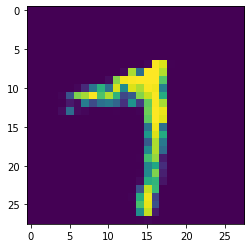

In [9]:
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(10, num_samples)
y_one_hot = np.zeros((num_samples, 10))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [10]:
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [FLAGS.batch_size, FLAGS.y_dim], name='y_sample')

# inputs_orig = {u'y': y_placeholder, u'z': z_placeholder}
# outputs_orig = dcgan.generator(inputs_orig)
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

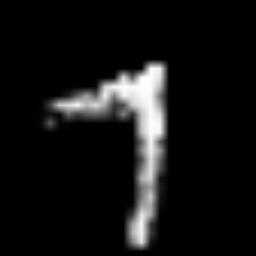

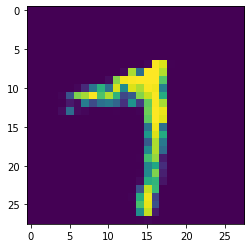

In [11]:
samples = sess.run(outputs_orig, feed_dict={z_placeholder: z_sample, y_placeholder: y_one_hot})
plt.imshow(samples[0,:,:,0])
imshow(samples[0,:,:,0])

In [12]:
img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)


In [13]:
z_new = z_placeholder+alpha*w
y_new = y_placeholder
transformed_output = dcgan.my_sampler(z_new, y_new)

In [14]:
loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.05
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

In [15]:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [16]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    print('outputs_zs.shape', outputs_zs.shape)
    if alpha == 0:
        return outputs_zs, mask_fn
    
    M = np.float32([[1,0,alpha],[0,1,0]])
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
        
    if show_img:
        print('Target image:')
#         imshow_unscaled(target_fn)
        imshow(target_fn[0,:,:,0], im_size=128)
    if show_mask:
        print('Target mask:')
#         imshow_unscaled(mask_out)
        imshow(mask_out[0,:,:,0], im_size=128)

    return target_fn, mask_out

In [17]:
! mkdir -p shift_l2_git/images
! mkdir -p shift_l2_git/output

In [18]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format('shift_l2_git', 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []

# train
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples=12800
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(10, num_samples)
    ys = np.zeros((num_samples, 10))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = 64
    loss_values = []

    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 6)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)
            Loss_sum = Loss_sum + curr_loss
            loss_values.append(curr_loss)

            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))
                
            alpha_list.append(alpha_val)

            if (optim_iter % 100 == 0) and (optim_iter > 0):
                saver.save(sess, './shift_l2_git/model_{}.ckpt'.format(optim_iter*batch_size), write_meta_graph=False, write_state=False)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, "./shift_l2_git/model_{}_final.ckpt".format(optim_iter*batch_size), write_meta_graph=False, write_state=False)
    return loss_values

In [19]:
train(dcgan.saver)


outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:30,943 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.24522686004638672, 0, 0, 0.20446433126926422, 3
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:30,962 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018416404724121094, 0, 64, 0.13352684676647186, -2
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:30,985 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02216315269470215, 0, 128, 0.13900771737098694, -2
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,003 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0175473690032959, 0, 192, 0.0895308405160904, -1
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,022 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018099308013916016, 0, 256, 0.1025230661034584, 1
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,038 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014631271362304688, 0, 320, 0.09148889034986496, 1
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,055 [MainThread  ] [INF

outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,813 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015201091766357422, 0, 3392, 0.09959868341684341, 2
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,829 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01470637321472168, 0, 3456, 0.040856536477804184, 1
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,844 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015150308609008789, 0, 3520, 0.09833276271820068, -3
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,866 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.021109819412231445, 0, 3584, 0.029972808435559273, -1
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,883 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01659536361694336, 0, 3648, 0.11302880197763443, -4
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,899 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01519155502319336, 0, 3712, 0.031200146302580833, 1
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:31,919 [Mai

outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:35,999 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020542621612548828, 0, 6784, 0.027630366384983063, -1
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:36,022 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.021764278411865234, 0, 6848, 0.10399919748306274, 3
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:36,042 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.019098758697509766, 0, 6912, 0.16330546140670776, -5
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:36,064 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02159571647644043, 0, 6976, 0.14445997774600983, 5
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:36,085 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02004265785217285, 0, 7040, 0.1250518262386322, 4
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:36,106 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02013397216796875, 0, 7104, 0.12629956007003784, -4
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:36,126 [MainTh

outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:37,140 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.019191503524780273, 0, 10176, 0.12409893423318863, 4
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:37,159 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018294572830200195, 0, 10240, 0.05868861451745033, -2
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:37,180 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020320653915405273, 0, 10304, 0.11861449480056763, 4
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:37,197 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01657843589782715, 0, 10368, 0.09291272610425949, -3
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:37,218 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.019646644592285156, 0, 10432, 0.05746474489569664, -2
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:37,238 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.019217252731323242, 0, 10496, 0.08959167450666428, -3
outputs_zs.shape (64, 28, 28, 1)
2019-08-17 17:08:37,25

[0.20446433,
 0.13352685,
 0.13900772,
 0.08953084,
 0.102523066,
 0.09148889,
 0.11279805,
 0.07489025,
 0.14433227,
 0.16218548,
 0.07600624,
 0.14857431,
 0.21955602,
 0.18196866,
 0.13798818,
 0.15596712,
 0.091367364,
 0.12702684,
 0.11624906,
 0.036382362,
 0.040431324,
 0.10455163,
 0.13741496,
 0.1235847,
 0.052262757,
 0.037544895,
 0.10689039,
 0.14270958,
 0.13775235,
 0.120658286,
 0.12263224,
 0.07316577,
 0.10968755,
 0.17961152,
 0.035868306,
 0.13690461,
 0.23071009,
 0.104805745,
 0.09399837,
 0.032956794,
 0.031085197,
 0.08927647,
 0.07720419,
 0.081028126,
 0.15326834,
 0.20089494,
 0.12088656,
 0.13210925,
 0.15377295,
 0.14794642,
 0.14628404,
 0.03775347,
 0.17542036,
 0.09959868,
 0.040856536,
 0.09833276,
 0.029972808,
 0.1130288,
 0.031200146,
 0.101289205,
 0.09733047,
 0.028565412,
 0.030298289,
 0.13177621,
 0.078623325,
 0.12006109,
 0.13021398,
 0.07477592,
 0.14962448,
 0.06421365,
 0.027119616,
 0.09606225,
 0.09875418,
 0.026467172,
 0.089585945,
 0.07

Input image:
Target image with alpha=-5:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-5, -5pix shift:
Target image with alpha=-4:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-4, -4pix shift:
Target image with alpha=-3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-3, -3pix shift:
Target image with alpha=-2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-2, -2pix shift:
Target image with alpha=-1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-1, -1pix shift:
Target image with alpha=0:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=0, 0pix shift:
Target image with alpha=1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=1, 1pix shift:
Target image with alpha=2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=2, 2pix shift:
Target image with alpha=3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=3, 3pix shift:
Target image with alpha=4:
outputs_z

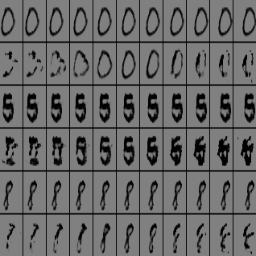

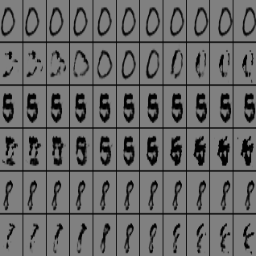

Input image:
Target image with alpha=-5:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-5, -5pix shift:
Target image with alpha=-4:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-4, -4pix shift:
Target image with alpha=-3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-3, -3pix shift:
Target image with alpha=-2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-2, -2pix shift:
Target image with alpha=-1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-1, -1pix shift:
Target image with alpha=0:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=0, 0pix shift:
Target image with alpha=1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=1, 1pix shift:
Target image with alpha=2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=2, 2pix shift:
Target image with alpha=3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=3, 3pix shift:
Target image with alpha=4:
outputs_z

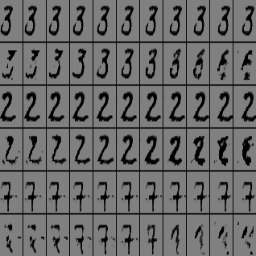

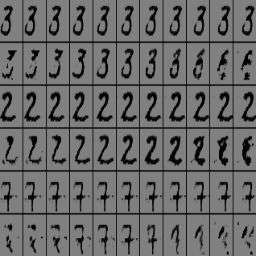

Input image:
Target image with alpha=-5:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-5, -5pix shift:
Target image with alpha=-4:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-4, -4pix shift:
Target image with alpha=-3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-3, -3pix shift:
Target image with alpha=-2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-2, -2pix shift:
Target image with alpha=-1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-1, -1pix shift:
Target image with alpha=0:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=0, 0pix shift:
Target image with alpha=1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=1, 1pix shift:
Target image with alpha=2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=2, 2pix shift:
Target image with alpha=3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=3, 3pix shift:
Target image with alpha=4:
outputs_z

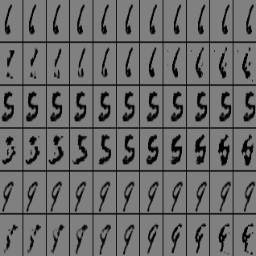

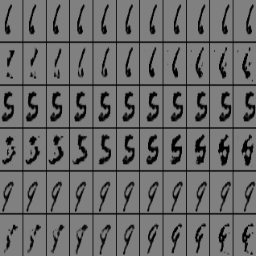

Input image:
Target image with alpha=-5:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-5, -5pix shift:
Target image with alpha=-4:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-4, -4pix shift:
Target image with alpha=-3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-3, -3pix shift:
Target image with alpha=-2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-2, -2pix shift:
Target image with alpha=-1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-1, -1pix shift:
Target image with alpha=0:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=0, 0pix shift:
Target image with alpha=1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=1, 1pix shift:
Target image with alpha=2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=2, 2pix shift:
Target image with alpha=3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=3, 3pix shift:
Target image with alpha=4:
outputs_z

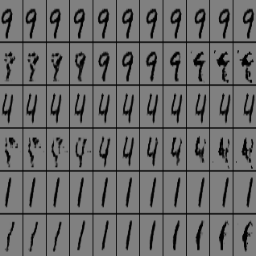

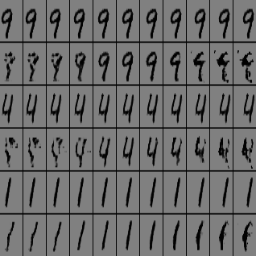

Input image:
Target image with alpha=-5:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-5, -5pix shift:
Target image with alpha=-4:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-4, -4pix shift:
Target image with alpha=-3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-3, -3pix shift:
Target image with alpha=-2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-2, -2pix shift:
Target image with alpha=-1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-1, -1pix shift:
Target image with alpha=0:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=0, 0pix shift:
Target image with alpha=1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=1, 1pix shift:
Target image with alpha=2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=2, 2pix shift:
Target image with alpha=3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=3, 3pix shift:
Target image with alpha=4:
outputs_z

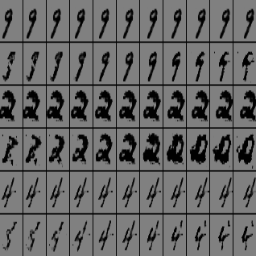

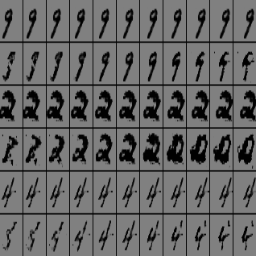

Input image:
Target image with alpha=-5:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-5, -5pix shift:
Target image with alpha=-4:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-4, -4pix shift:
Target image with alpha=-3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-3, -3pix shift:
Target image with alpha=-2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-2, -2pix shift:
Target image with alpha=-1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-1, -1pix shift:
Target image with alpha=0:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=0, 0pix shift:
Target image with alpha=1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=1, 1pix shift:
Target image with alpha=2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=2, 2pix shift:
Target image with alpha=3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=3, 3pix shift:
Target image with alpha=4:
outputs_z

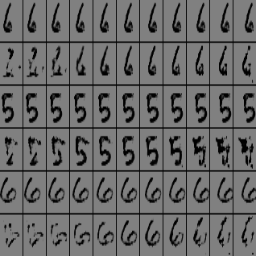

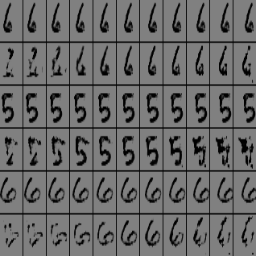

Input image:
Target image with alpha=-5:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-5, -5pix shift:
Target image with alpha=-4:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-4, -4pix shift:
Target image with alpha=-3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-3, -3pix shift:
Target image with alpha=-2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-2, -2pix shift:
Target image with alpha=-1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-1, -1pix shift:
Target image with alpha=0:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=0, 0pix shift:
Target image with alpha=1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=1, 1pix shift:
Target image with alpha=2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=2, 2pix shift:
Target image with alpha=3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=3, 3pix shift:
Target image with alpha=4:
outputs_z

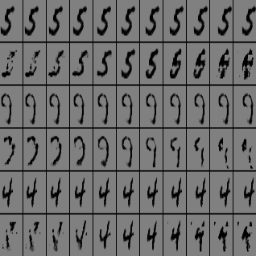

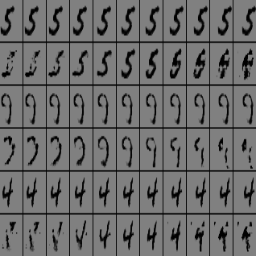

Input image:
Target image with alpha=-5:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-5, -5pix shift:
Target image with alpha=-4:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-4, -4pix shift:
Target image with alpha=-3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-3, -3pix shift:
Target image with alpha=-2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-2, -2pix shift:
Target image with alpha=-1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-1, -1pix shift:
Target image with alpha=0:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=0, 0pix shift:
Target image with alpha=1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=1, 1pix shift:
Target image with alpha=2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=2, 2pix shift:
Target image with alpha=3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=3, 3pix shift:
Target image with alpha=4:
outputs_z

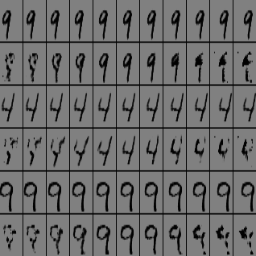

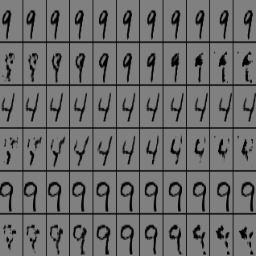

Input image:
Target image with alpha=-5:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-5, -5pix shift:
Target image with alpha=-4:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-4, -4pix shift:
Target image with alpha=-3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-3, -3pix shift:
Target image with alpha=-2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-2, -2pix shift:
Target image with alpha=-1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-1, -1pix shift:
Target image with alpha=0:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=0, 0pix shift:
Target image with alpha=1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=1, 1pix shift:
Target image with alpha=2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=2, 2pix shift:
Target image with alpha=3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=3, 3pix shift:
Target image with alpha=4:
outputs_z

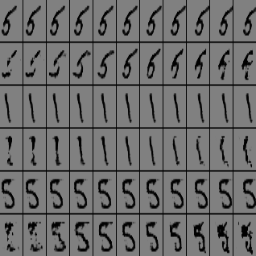

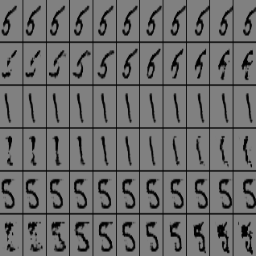

Input image:
Target image with alpha=-5:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-5, -5pix shift:
Target image with alpha=-4:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-4, -4pix shift:
Target image with alpha=-3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-3, -3pix shift:
Target image with alpha=-2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-2, -2pix shift:
Target image with alpha=-1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=-1, -1pix shift:
Target image with alpha=0:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=0, 0pix shift:
Target image with alpha=1:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=1, 1pix shift:
Target image with alpha=2:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=2, 2pix shift:
Target image with alpha=3:
outputs_zs.shape (64, 28, 28, 1)
Transformed image with alpha=3, 3pix shift:
Target image with alpha=4:
outputs_z

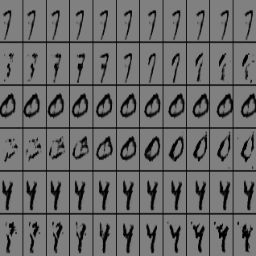

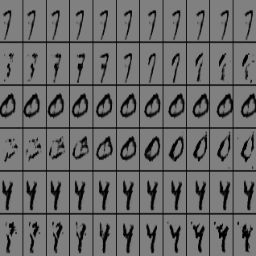

In [20]:
# test: show imgs 
# this can be test.py

np.random.seed(0)
categories = np.random.choice(10, 10, replace=False)
# categories = [449] # [207, 283, 751, 949, 963, 973, 970, 978]

a = np.arange(-5,6,1)
 
num_samples=64

for c in range(len(categories)):

    ims_zoomed = []
    ims_target = []
    ims_mask = []

    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    y = np.random.choice(10, num_samples)
    ys = np.zeros((num_samples, 10))
    ys[np.arange(num_samples), y] = 1

    input_test = {y_placeholder: ys,
                  z_placeholder: zs}
    
    out_input_test = sess.run(outputs_orig, input_test)
    print('Input image:')    
#     print(np.expand_dims(out_input_test[0,:,:,:], 0).shape)
    # imshow_unscaled(np.expand_dims(out_input_test[0,:,:,:], 0))
    
    for i in range(a.shape[0]):
        print('Target image with alpha={}:'.format(a[i]))
        target_fn, mask_out = get_target_np(out_input_test, a[i], show_img=False)
        best_inputs = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}#, input_step_sizes: step_sizes}
        best_im_out, best_loss = sess.run([transformed_output, loss], best_inputs)
        baseline_loss = sess.run(loss, feed_dict={mask: mask_out, target: target_fn, 
                                                  transformed_output: out_input_test})
        
        print('Transformed image with alpha={}, {}pix shift:'.format(a[i], a[i]))
        # imshow_unscaled(np.expand_dims(best_im_out[0,:,:,:], 0))
        # imshow_unscaled(best_im_out)
        
        # collect outputs
        ims_zoomed.append(best_im_out)
        ims_target.append(target_fn)
        ims_mask.append(mask_out)
    
   # save image without mask
    ims = []
    for j in range(min(num_samples, 3)):
        top_row = np.stack([x[j, :, :, :] for x in ims_target], axis=0)
        top_row = np.uint8 (np.clip(((top_row + 1) / 2.0) * 256, 0, 255))
        bottom_row = np.stack([x[j, :, :, :] for x in ims_zoomed], axis=0)
        bottom_row = np.uint8(np.clip(((bottom_row + 1) / 2.0) * 256, 0, 255))
        # add a green stripe down the center for alignment
        _, _, width, _ = top_row.shape
#         top_row[:, :, width//2-1:width//2+3, 0] = 255
#         bottom_row[:, :, width//2-1:width//2+3, 0] = 255
        ims.append(np.concatenate((top_row,bottom_row), axis=0))
    ims = np.concatenate(ims, axis=0)
    imshow(imgrid(ims, cols=len(a)), filename='shift_l2_git/images/grouped-{}-{}'.format(categories[c], 0))
    
    # save image with mask
    ims = []
    for j in range(min(num_samples, 3)):
        top_row = np.stack([x[j, :, :, :] for x in ims_target], axis=0)
        top_row = np.uint8 (np.clip(((top_row + 1) / 2.0) * 256, 0, 255))
        bottom_row = np.stack([x[j, :, :, :] * y[j, :, :, :] for x, y in zip(ims_zoomed, ims_mask)], axis=0)
        bottom_row = np.uint8(np.clip(((bottom_row + 1) / 2.0) * 256, 0, 255))
        # add a green stripe down the center for alignment
        _, _, width, _ = top_row.shape
#         top_row[:, :, width//2-1:width//2+3, 0] = 255
#         bottom_row[:, :, width//2-1:width//2+3, 0] = 255
        ims.append(np.concatenate((top_row,bottom_row), axis=0))
    ims = np.concatenate(ims, axis=0)
    imshow(imgrid(ims, cols=len(a)), filename='shift_l2_git/images/grouped-{}-{}-mask'.format(categories[c], 0))
    
    
    